In [190]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [191]:
data = pd.read_csv('UNRATE.csv', header = None)
data.columns = ['DATE' ,'UNRATE']
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')
data = data.set_index('DATE')
data.head()


,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


## Time series analysis

### Plot time series data

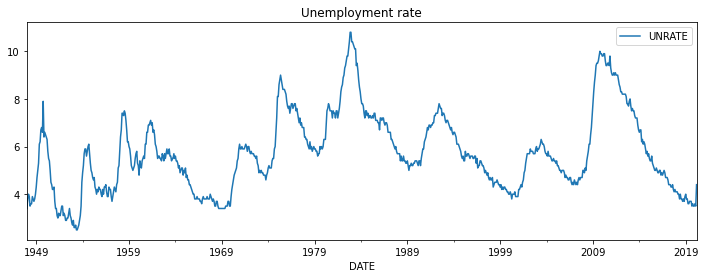

In [192]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Unemployment rate')
plt.show(block=False)

### Time series Decomposition

#### Additive seasonal decomposition

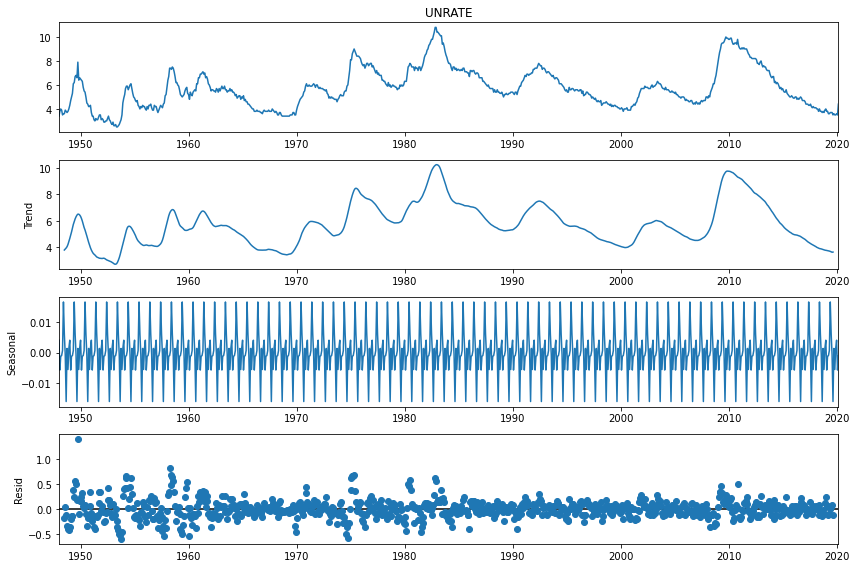

In [193]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.UNRATE, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

#### Multiplicative seasonal decomposition

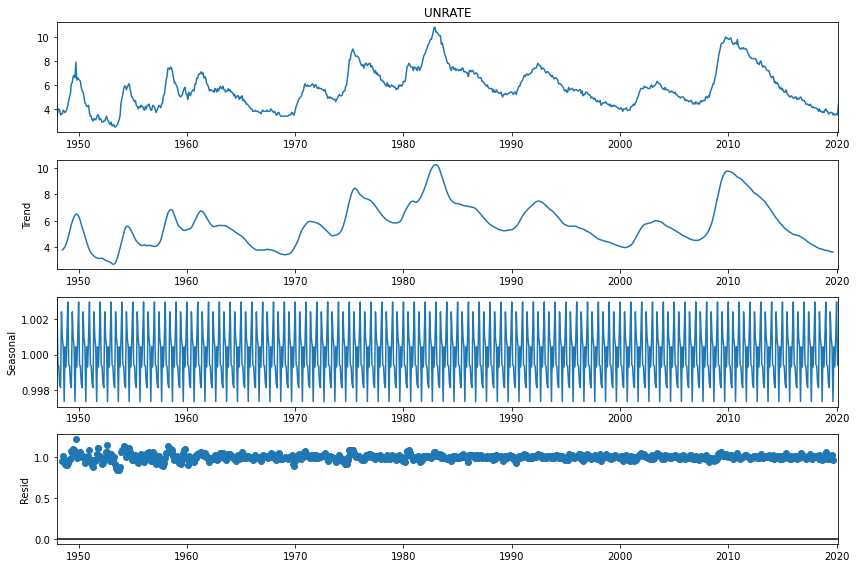

In [194]:
decomposition = sm.tsa.seasonal_decompose(data.UNRATE, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

### Build and evaluate time series forecast

#### Split time series data into training and test set

In [195]:
train_len =  612
train = data[0:train_len] # first 612 months as training set
test = data[train_len:] # last 255 months as out-of-time test set

### Auto Regressive methods

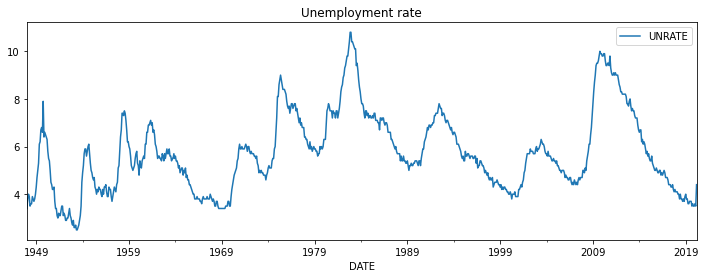

In [196]:
data['UNRATE'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Unemployment rate')
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test

In [197]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['UNRATE'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.143963
Critical Values @ 0.05: -2.86
p-value: 0.023466


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [198]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['UNRATE'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.464446
Critical Values @ 0.05: 0.46
p-value: 0.049674


#### Box Cox transformation to make variance constant

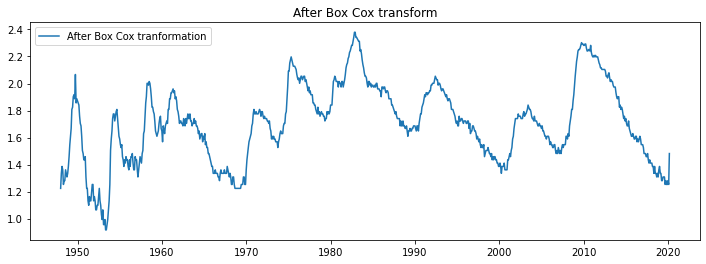

In [199]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['UNRATE'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

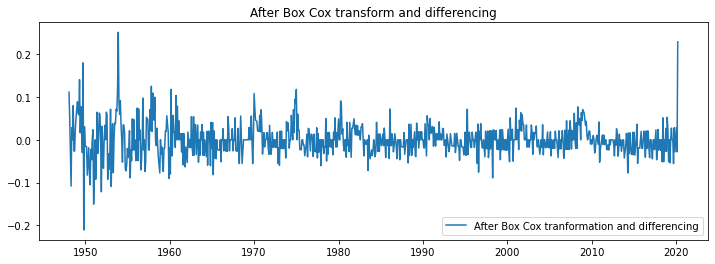

In [200]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [201]:
data_boxcox_diff.dropna(inplace=True)

In [202]:
data_boxcox_diff.tail()

DATE
2019-11-01   -0.028171
2019-12-01    0.000000
2020-01-01    0.028171
2020-02-01   -0.028171
2020-03-01    0.228842
dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [203]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.918955
Critical Values @ 0.05: -2.86
p-value: 0.000000


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [204]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.062761
Critical Values @ 0.05: 0.46
p-value: 0.100000


### Autocorrelation function (ACF)

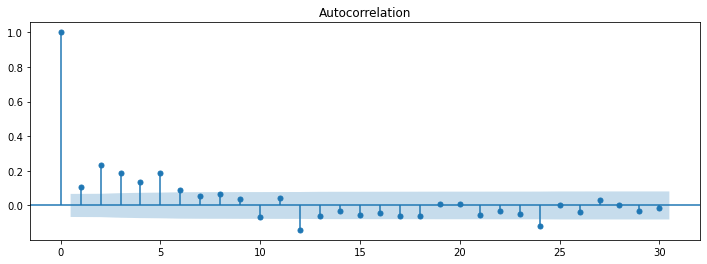

In [205]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

### Partial autocorrelation function (PACF)

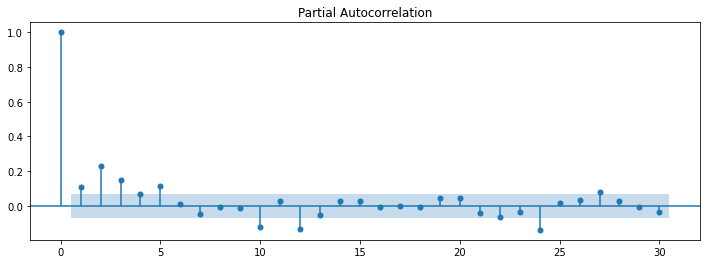

In [206]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [207]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [208]:
train_data_boxcox_diff

DATE
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
1948-06-01    0.028171
                ...   
1998-08-01    0.000000
1998-09-01    0.021979
1998-10-01   -0.021979
1998-11-01   -0.022473
1998-12-01    0.000000
Length: 611, dtype: float64

### Auto regression method (AR)

In [209]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148533
dtype: float64


### Recover original time series

In [210]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])
y_hat_ar['ar_forecast']

1948-02-01    3.401586
1948-03-01    3.453112
1948-04-01    3.559367
1948-05-01    3.651090
1948-06-01    3.670434
                ...   
2019-11-01    5.049066
2019-12-01    5.051421
2020-01-01    5.053777
2020-02-01    5.056135
2020-03-01    5.058493
Freq: MS, Length: 866, dtype: float64

### Plot train, test and forecast

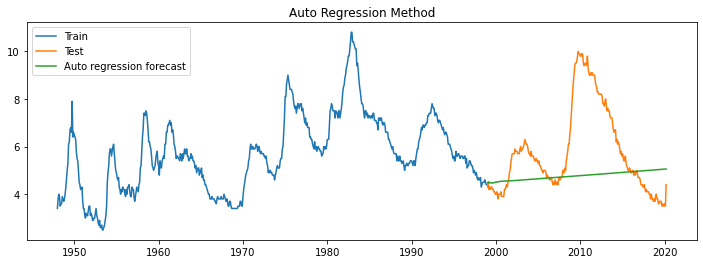

In [211]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [212]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ar['ar_forecast'][test.index.min():])/test['UNRATE'])*100,2)

Results = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([results, tempResults])
Results = Results[['Method', 'RMSE', 'MAPE']]
Results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.5


### Moving average method (MA)

In [213]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


### Recover original time series

In [214]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])
y_hat_ma['ma_forecast']

1948-02-01    3.401726
1948-03-01    3.443834
1948-04-01    3.537628
1948-05-01    3.611959
1948-06-01    3.610562
                ...   
2019-11-01    5.162574
2019-12-01    5.165194
2020-01-01    5.167816
2020-02-01    5.170439
2020-03-01    5.173063
Freq: MS, Length: 866, dtype: float64

### Plot train, test and forecast

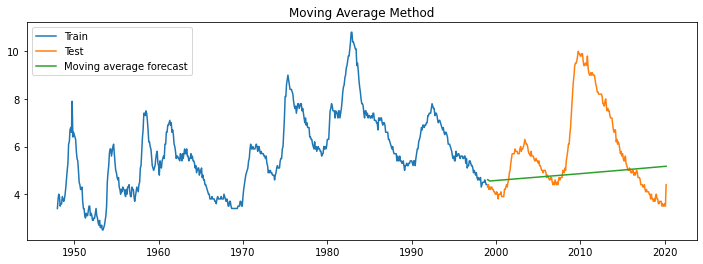

In [215]:
plt.figure(figsize=(12,4))
plt.plot(data['UNRATE'][:train_len], label='Train')
plt.plot(data['UNRATE'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [216]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ma['ma_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
Results = pd.concat([Results, tempResults])
Results = Results[['Method', 'RMSE', 'MAPE']]
Results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.5
0,Moving Average (MA) method,2.03,21.6


### Auto regressive integrated moving average (ARIMA)

In [217]:
model = ARIMA(train_data_boxcox, order=(12, 1, 5))
model_fit = model.fit()
print(model_fit.params)

const         0.000458
ar.L1.D.y    -0.089800
ar.L2.D.y     0.662768
ar.L3.D.y     0.486907
ar.L4.D.y    -0.467094
ar.L5.D.y    -0.595201
ar.L6.D.y     0.048377
ar.L7.D.y     0.049981
ar.L8.D.y     0.098205
ar.L9.D.y     0.134788
ar.L10.D.y   -0.047134
ar.L11.D.y    0.008280
ar.L12.D.y   -0.073229
ma.L1.D.y     0.120342
ma.L2.D.y    -0.504685
ma.L3.D.y    -0.362542
ma.L4.D.y     0.519214
ma.L5.D.y     0.663627
dtype: float64


### Recover original time series forecast

In [218]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

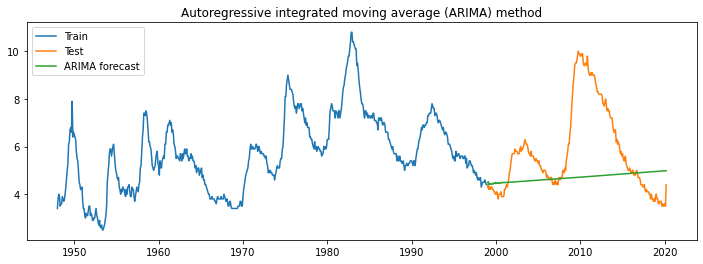

In [219]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [220]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_arima['arima_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
Results = pd.concat([Results, tResults])
Results = Results[['Method', 'RMSE', 'MAPE']]
Results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.5
0,Moving Average (MA) method,2.03,21.6
0,Autoregressive integrated moving average (ARIM...,2.10,21.6


### Seasonal auto regressive integrated moving average (SARIMA)

In [221]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.598953
ar.L2       0.119680
ma.L1      -0.563745
ma.L2      -0.001190
ma.L3       0.067181
ma.L4       0.055138
ar.S.L12   -0.932682
ar.S.L24   -0.511869
ma.S.L12   -0.280399
ma.S.L24   -0.532374
ma.S.L36   -0.402425
ma.S.L48    0.268691
sigma2      0.001493
dtype: float64


### Recover original time series forecast

In [222]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

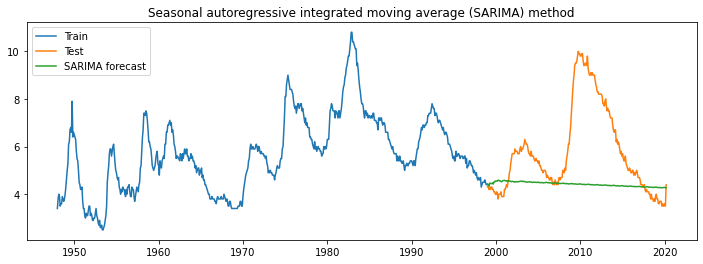

In [223]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [224]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
Results = pd.concat([Results, tempResults])
Results = Results[['Method', 'RMSE', 'MAPE']]
Results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.50
0,Moving Average (MA) method,2.03,21.60
0,Autoregressive integrated moving average (ARIM...,2.10,21.60
0,Seasonal autoregressive integrated moving aver...,2.26,22.13
